In [1]:
import pickle

x_train, y_train = pickle.load(open('../outputs/train_xy.pk', 'rb'))
x_cv, y_cv = pickle.load(open('../outputs/val_xy.pk', 'rb'))
x_test, y_test = pickle.load(open('../outputs/test_xy.pk', 'rb'))
print('shapes of train, validation, test data', x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)

shapes of train, validation, test data (1576366, 128) (1576366,) (143303, 128) (143303,) (238838, 128) (238838,)


In [15]:
params = {'batch_size':5000, 'input_size':x_train.shape[1], 'hidden_units_1':256, 'hidden_units_2':100, 'output_size':1, 'lr': 1e-3, 'min_lr':1e-6, 'max_lr':1e-3, 'epochs': 500}
# 0.00012 to 0.0002

In [16]:
import torch
from torch.utils import data as torch_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

trainset = torch_data.TensorDataset(torch.as_tensor(x_train, dtype=torch.float, device=device), torch.as_tensor(y_train, dtype=torch.float, device=device))
train_dl = torch_data.DataLoader(trainset, batch_size=params['batch_size'], drop_last=True)

val_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_cv, dtype=torch.float, device=device), torch.as_tensor(y_cv, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

test_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_test, dtype=torch.float, device=device), torch.as_tensor(y_test, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

device: cuda:0


In [18]:
from torchsummary import summary

torch.manual_seed(9999)
def get_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(params['input_size'], params['hidden_units_1']),
        torch.nn.Dropout(p=0.05),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_1'], params['hidden_units_2']),
        torch.nn.Dropout(p=0.04),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_2'], params['output_size']),
        torch.nn.ReLU(),
        # torch.nn.Softplus(),
    )
    model.to(device)
    return model

def poisson_loss(y_pred, y_true):
    """
    Custom loss function for Poisson model.
    Equivalent Keras implementation for reference:
    K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)
    For output of shape (2,3) it return (2,) vector. Need to calculate
    mean of that too.
    """
    y_pred = torch.squeeze(y_pred)
    loss = torch.mean(y_pred - y_true * torch.log(y_pred+1e-7))
    return loss

model = get_model()

print('model loaded into device=', next(model.parameters()).device)
summary(model, input_size=(128, ))

lr_reduce_patience = 20
lr_reduce_factor = 0.5

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, dampening=0, weight_decay=0, nesterov=True)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=params['lr'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_reduce_factor, patience=lr_reduce_patience, verbose=True, threshold=0.00001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08)
# lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=params['max_lr'], steps_per_epoch=len(train_dl), epochs=params['epochs'], div_factor=1e3)
lr_sched = torch.optim.lr_scheduler.CyclicLR(optimizer, params['min_lr'], params['max_lr'], step_size_up=4*len(train_dl), step_size_down=None, mode='triangular', last_epoch=-1)  # 1e-6, 1e-2, 4or8*len(train_dl), scale_mode=req for custom scale, last_epoch= num_of_iters_calculated--pass prev train iters if resuming 
for param_group in optimizer.param_groups:
    print(param_group['lr'])

model loaded into device= cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          33,024
           Dropout-2                  [-1, 256]               0
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 100]          25,700
           Dropout-5                  [-1, 100]               0
              ReLU-6                  [-1, 100]               0
            Linear-7                    [-1, 1]             101
              ReLU-8                    [-1, 1]               0
Total params: 58,825
Trainable params: 58,825
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.22
Estimated Total Size (MB): 0.23
----------------------------------------------------------------
1e-06


#### Run next cell to find optimal range for learning rate while using One-Cycle LR scheduler
In this case choosing the learning rate from graph below didn't help (same training speed as previoius range). Why?

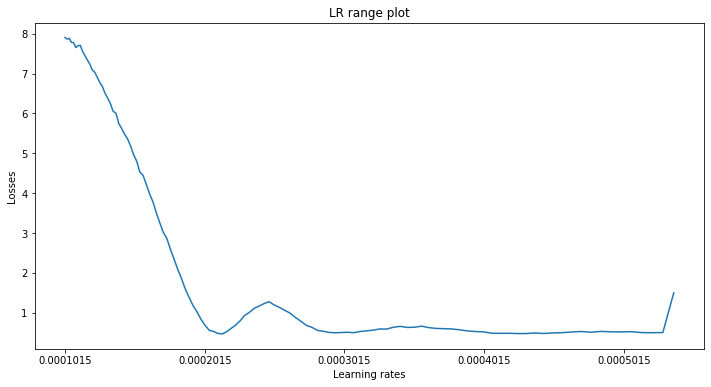

In [11]:
from lr_range_finder import LrRangeFinder

model.train()
lr_range_finder = LrRangeFinder(len(train_dl), x=x_train, y=y_train, lr_low=params['lr'], lr_high=params['max_lr'])
last_loss = None

for i, data in enumerate(train_dl, 0):
    # get the inputs; data is a list of [inputs, dist_true]
    inputs, dist_true = data[0], data[1]
    
    # get loss for current iteration
    curr_lr = lr_range_finder.get_next_lr(last_loss)
    if not curr_lr:
        break
    for param_group in optimizer.param_groups:
        param_group['lr'] = curr_lr
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = loss_fn(outputs, dist_true)

    loss.backward()
    optimizer.step()

    last_loss = loss.item()

lr_range_finder.plot_lr()

In [ ]:
import math

def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(train_dl)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_dl:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs, labels = data
        # inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
        #if batch_num % 10 == 0:
        # print('batch_num:', batch_num, 'lr=', lr, 'smoothed_loss=', smoothed_loss, 'best_loss=', best_loss)
    return log_lrs, losses

lrs, losses = find_lr()
print('returned')
plt.figure()
plt.plot(lrs, losses)
plt.xticks(np.arange(min(lrs), max(lrs), 0.0001))
plt.title('LR range plot')
plt.xlabel('Learning rates')
plt.ylabel('Losses')
plt.show()

In [19]:
def evaluate(model, dl):
    model.eval()
    final_loss = 0.0
    count = 0
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl)

def save_checkpoint(state, state_save_path):
    if not os.path.exists("/".join(state_save_path.split('/')[:-1])):
        os.makedirs("/".join(state_save_path.split('/')[:-1]))
    torch.save(state, state_save_path)

In [11]:
%%time
# %load_ext tensorboard

import time
import copy
from tqdm.auto import tqdm
from utils import *
from torch.utils.tensorboard import SummaryWriter
# from tensorboardX import SummaryWriter

last_loss = 0.0
min_val_loss = np.inf
patience_counter = 0
early_stop_patience = 50
best_model = None
train_losses = []
val_losses = []

output_path = '../outputs'
tb_path = output_path+'/logs/runs'
run_path = tb_path+'/run18_smlMaxLr_triangle'
checkpoint_path = run_path+'/checkpoints'
resume_training = False
start_epoch = 0
iter_count = 0

if os.path.exists(run_path):
    raise Exception("this experiment already exists!")

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

writer = SummaryWriter(log_dir=run_path, comment='', purge_step=None, max_queue=1, flush_secs=50, filename_suffix='')

# resume training on a saved model
if resume_training:
    prev_checkpoint_path = '../outputs/logs/runs/run16/checkpoints'  
    model.load_state_dict(torch.load(prev_checkpoint_path+'/model_1589727955.160865.pt'))
    optimizer.load_state_dict(torch.load(prev_checkpoint_path+'/optim_1589727955.160865.pt'))
    lr_sched.load_state_dict(torch.load(prev_checkpoint_path+'/sched_1589727955.160865.pt')) 
    start_epoch = 500
    writer.add_text('loaded saved model:', str(params))
    print('loaded saved model', params)

writer.add_text('run_change', 'smaller max lr, mode=triangular instead of triang2' + str(params))

torch.backends.cudnn.benchmark = True
print('total epochs=', len(range(start_epoch, start_epoch+params['epochs'])))
# epoch_bar = tqdm(range(epochs), ncols=12000)  # tqdm really slows down training! 
# with torch.autograd.detect_anomaly():
for param_group in optimizer.param_groups:
    print('lr-check', param_group['lr'])
for epoch in range(start_epoch, start_epoch+params['epochs']):  # loop over the dataset multiple times
    running_loss = 0.0
    stime = time.time()
    
    for i, data in enumerate(train_dl, 0):
        iter_count += 1
        # get the inputs; data is a list of [inputs, dist_true]
        model.train()
        inputs, dist_true = data[0], data[1]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, dist_true)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        last_loss = loss.item()

        lr_sched.step()

    val_loss = evaluate(model, val_dl)
    # lr_sched.step(val_loss)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        best_model = copy.deepcopy(model)
        print(epoch,"> Best val_loss model saved:", round(val_loss, 3))
    else:
        patience_counter += 1
    train_loss = running_loss/len(train_dl)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    writer.add_scalar('loss/train', train_loss, epoch)
    writer.add_scalar('loss/val', val_loss, epoch)
    for param_group in optimizer.param_groups:
        curr_lr = param_group['lr']
    writer.add_scalar('monitor/lr', curr_lr, epoch)
    if patience_counter > early_stop_patience:
        print("Early stopping at epoch {}. current val_loss {}".format(epoch, val_loss))
        break

    if epoch % 10 == 0:
        torch.save(best_model.state_dict(), checkpoint_path+'/best_model.pt')
        torch.save(optimizer.state_dict(), checkpoint_path+'/optim_cp.pt')
        torch.save(lr_sched.state_dict(), checkpoint_path+'/sched_cp.pt')
        writer.add_text('checkpoint saved', 'at epoch='+str(epoch))
        print("epoch:{} -> train_loss={},val_loss={} - {}".format(epoch, round(train_loss, 5),                round(val_loss, 5), seconds_to_minutes(time.time()-stime)))
    # epoch_bar.update(1)
    # epoch_bar.set_description(desc="train_loss={},val_loss={},running_loss={}".format(round(last_loss,3), round(val_loss,3), running_loss))

print('Finished Training')
ts = str(time.time())
best_model_path = checkpoint_path+'/model_'+ts+'.pt'
opt_save_path = checkpoint_path+'/optim_'+ts+'.pt'
sched_save_path = checkpoint_path+'/sched_'+ts+'.pt'
state_save_path = checkpoint_path+'/state_'+ts+'.pt'
state = {'epoch': epoch+1,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict(),
        'last_train_loss': train_losses[-1],
        'last_val_loss': val_losses[-1],
        'total_iters': iter_count
        }

save_checkpoint(state, state_save_path)
# sometimes loading from state dict is not wokring, so...
torch.save(best_model.state_dict(), best_model_path)
torch.save(optimizer.state_dict(), opt_save_path)
torch.save(lr_sched.state_dict(), sched_save_path)

total epochs= 500
lr-check 1e-06
0 > Best val_loss model saved: 18.787
epoch:0 -> train_loss=1.25992,val_loss=18.78697 - 0.0 minutes 49.0 seconds
1 > Best val_loss model saved: 17.534
7 > Best val_loss model saved: 4.78
epoch:10 -> train_loss=1.66133,val_loss=18.3091 - 0.0 minutes 48.0 seconds
15 > Best val_loss model saved: 2.01
epoch:20 -> train_loss=1.91818,val_loss=16.38942 - 0.0 minutes 48.0 seconds
23 > Best val_loss model saved: 1.54
epoch:30 -> train_loss=4.21244,val_loss=4.84417 - 0.0 minutes 48.0 seconds
epoch:40 -> train_loss=3.72724,val_loss=2.36984 - 0.0 minutes 49.0 seconds
epoch:50 -> train_loss=3.82634,val_loss=2.74228 - 0.0 minutes 47.0 seconds
epoch:60 -> train_loss=3.91346,val_loss=2.31262 - 0.0 minutes 47.0 seconds
epoch:70 -> train_loss=3.84666,val_loss=1.9981 - 0.0 minutes 51.0 seconds
Early stopping at epoch 74. current val_loss 2.0278725836958205
Finished Training
Wall time: 1h 30s


In [12]:
def test(model, dl):
    model.eval()
    final_loss = 0.0
    count = 0
    y_hat = []
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            y_hat.extend(outputs.tolist())
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl), y_hat

best_model_path = '../outputs/logs/runs/run15_part7_reduceLR/checkpoints/model_1589668768.0690324.pt'
model.load_state_dict(torch.load(best_model_path))
test_loss, y_hat = test(model, test_dl)
print(test_loss)
y_hat[50:60], y_test[50:60]

0.8744956610050607


([[2.897994041442871],
  [3.1946303844451904],
  [2.6536667346954346],
  [2.745253086090088],
  [3.5094351768493652],
  [2.726296901702881],
  [2.7429428100585938],
  [2.6536667346954346],
  [2.6536667346954346],
  [2.6561107635498047]],
 array([3, 3, 2, 3, 4, 1, 3, 2, 2, 3]))

238838 235000


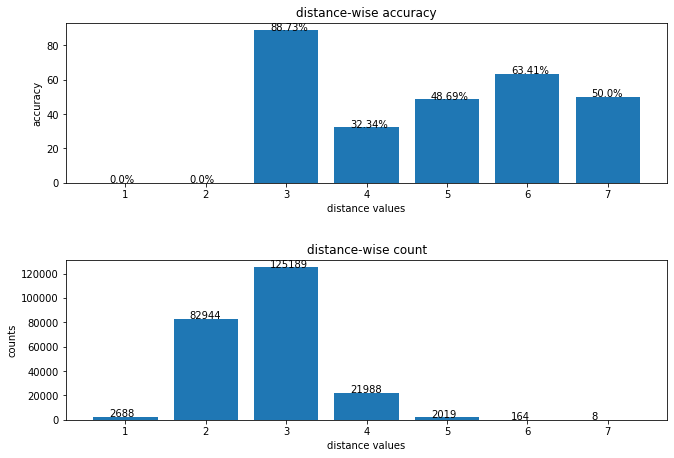

In [13]:
# show distance value wise precision (bar chart)
# predicted values are less that real test samples because last samples from test are dropped # to maintain save batch size (drop_last=True)
from matplotlib import pyplot as plt

y_hat_ = np.array(y_hat).squeeze()
y_test_ = y_test[:len(y_hat)]
print(len(y_test), len(y_hat))
dist_accuracies = []
dist_counts = [] 
for i in range(1, 8):
    mask = y_test_==i
    dist_values = y_test_[mask]
    dist_preds = np.round(y_hat_[mask])
    # print(len(mask), len(dist_values), len(dist_preds))
    # print(i, np.sum(np.equal(dist_values, dist_preds)), len(dist_values))
    dist_accuracies.append(np.sum(dist_values == dist_preds)*100/len(dist_values))
    dist_counts.append(len(dist_values))

fig = plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.bar(range(1,8), dist_accuracies)
for index, value in enumerate(dist_accuracies):
    plt.text(index+0.8, value, str(np.round(value, 2))+'%')
plt.title('distance-wise accuracy')
plt.xlabel('distance values')
plt.ylabel('accuracy')
plt.subplot(2,1,2)
plt.bar(range(1,8), dist_counts)
for index, value in enumerate(dist_counts):
    plt.text(index+0.8, value, str(value))
plt.title('distance-wise count')
plt.xlabel('distance values')
plt.ylabel('counts')
fig.tight_layout(pad=3.0)
plt.show()
writer.add_figure('test/results', fig)

In [7]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.001


#### Things to try
* Next try one cycle lr sched -- 
* Distance values of 2 & 3 dominate the data. Best way to handle?
* try batch normalization
* normalize outputs?
* try Mean Absolute Error (robust to large/small outliers) and Mean Sq log error.
* are features good enough for prediction? Check it. May be try XGBoost for it.
* stratified data
* check one-cycle LR and loss correlation. Log it in tensorboard.
* print out outputs to see why loss so high?